# Dokumentasi Model Deteksi & Klasifikasi Esai Siswa dan ChatGPT

Notebook ini bertujuan untuk membangun sistem klasifikasi esai siswa dan ChatPGT menggunakan dua dataset: Student_ChatGPT dan Only_ChatGPT. Sistem ini mencakup arsitektur Bi-Encoder dan classifier untuk membedakan teks dari Student dan ChatGPT. Dokumentasi ini memandu Anda melalui proses pembentukan sistem secara bertahap.

## 1. Import Library

Pada langkah ini, semua library yang diperlukan untuk pemrosesan teks, pembelajaran mesin, dan visualisasi data diimpor:

In [ ]:
#Import Library
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import numpy as np
import pandas as pd
import pickle
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from collections import Counter
import re
import matplotlib.pyplot as plt
import seaborn as sns
import random

## 2. Load Dataset

Dua dataset utama diimpor:
1. Dataset Student_ChatGPT: Berisi interaksi antara Student dan ChatGPT dengan format:
- Kolom 1: Teks dari Student.
- Kolom 2: Respon dari ChatGPT.
2. Dataset Only_ChatGPT: Berisi teks yang dihasilkan oleh ChatGPT terkait pengetahuan satu mata pelajaran selama satu tahun (2 semester).

Dataset ini digunakan untuk membangun model Bi-Encoder dan classifier.

In [101]:
# Load both datasets
student_chatgpt = pd.read_excel("example_datasets/examples-datasets-mar25.xlsx")
only_chatgpt = pd.read_excel("example_datasets/knowledge-datasets-mar25.xlsx")

In [102]:
# Tampilkan informasi dataset
print("Dataset Student_ChatGPT:")
print(student_chatgpt.info())
print("\nDataset Only_ChatGPT:")
print(only_chatgpt.info())

# Tampilkan beberapa baris awal dataset
print("\nContoh Data Student_ChatGPT:")
display(student_chatgpt.head())

print("\nContoh Data Only_ChatGPT:")
display(only_chatgpt.head())

Dataset Student_ChatGPT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pelajar  43 non-null     object
 1   GPT      43 non-null     object
dtypes: object(2)
memory usage: 820.0+ bytes
None

Dataset Only_ChatGPT:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   GPT     118 non-null    object
dtypes: object(1)
memory usage: 1.1+ KB
None

Contoh Data Student_ChatGPT:


,Pelajar,GPT
0,Teknologi adalah segala sesuatu yang menciptak...,Teknologi adalah alat atau sistem yang dicipta...
1,"Sekarang, mari kita lihat fakta umum yang seri...","Dalam kehidupan sehari-hari, teknologi memenga..."
2,"Jika ditelisik lebih jauh, sudah banyak kiprah...","Selain itu, tantangan besar lainnya adalah ban..."
3,Lalu sebenarnya apa saja peran pelajar yang da...,Masyarakat memiliki pandangan yang beragam ter...
4,Salah satu pelajar yang berkiprah dalam menyok...,Salah satu contoh positif dari pemanfaatan tek...



Contoh Data Only_ChatGPT:


,GPT
0,Teknologi adalah sekumpulan pengetahuan dan ke...
1,"Di era digital ini, pelajar menghadapi berbaga..."
2,Masyarakat memiliki pandangan yang beragam ter...
3,Salah satu contoh nyata dari pelajar yang berh...
4,"Namun, untuk dapat berhasil dalam memanfaatkan..."


## 3. Preprocessing Data

Langkah ini memproses data mentah menjadi format yang siap digunakan oleh model:
1. Preprocessing Teks:
- Semua teks diubah menjadi huruf kecil.
- Teks dipisahkan menjadi kalimat menggunakan tokenisasi kalimat.
2. Distribusi Data:
- Total jumlah kalimat dari masing-masing sumber (Student, ChatGPT dari Student_ChatGPT, dan Only_ChatGPT) dihitung dan ditampilkan.

In [ ]:
def preprocess_text(text):
    """
    Preprocessing teks:
    - Mengubah teks menjadi huruf kecil.
    - Membagi teks menjadi kalimat (tokenisasi kalimat) menggunakan regex.
    - Tanda baca terakhir (., ?, !) tetap disertakan dalam hasil tokenisasi.

    Args:
        text (str): Teks input.

    Returns:
        list: Daftar kalimat yang telah diproses.
    """
    if not isinstance(text, str) or text.strip() == "":
        return []

    # Ubah teks menjadi huruf kecil dan hilangkan spasi di awal/akhir
    text = text.lower().strip()

    # Tokenisasi kalimat menggunakan regex
    sentences = re.findall(r'.+?[.!?](?=\s|$)', text)
    # Hapus elemen kosong dari hasil split (jika ada)
    sentences = [sentence.strip() for sentence in sentences if sentence.strip()]

    return sentences

# Preprocessing data Student_ChatGPT
student_sentences = []
chatgpt_sentences_1 = []  # ChatGPT dari dataset Student_ChatGPT

# Proses teks Student
for text in student_chatgpt['Pelajar']:
    student_sentences.extend(preprocess_text(text))

# Proses teks ChatGPT (dari Student_ChatGPT)
for text in student_chatgpt['GPT']:
    chatgpt_sentences_1.extend(preprocess_text(text))

# Preprocessing data Only_ChatGPT
chatgpt_sentences_2 = []  # ChatGPT dari dataset Only_ChatGPT

# Proses teks ChatGPT (dari Only_ChatGPT)
for text in only_chatgpt['GPT']:
    chatgpt_sentences_2.extend(preprocess_text(text))

# Tampilkan jumlah data hasil preprocessing
print(f"Total kalimat Student: {len(student_sentences)}")
print(f"Total kalimat ChatGPT (Student_ChatGPT): {len(chatgpt_sentences_1)}")
print(f"Total kalimat ChatGPT (Only_ChatGPT): {len(chatgpt_sentences_2)}")

Total kalimat Student: 168
Total kalimat ChatGPT (Student_ChatGPT): 186
Total kalimat ChatGPT (Only_ChatGPT): 413


## 7. Inisialisasi BERT Tokenizer

Teks dari dataset di-tokenisasi menggunakan tokenizer pretrained dari IndoBERT:
- `input_ids`: Token ID untuk setiap kata dalam teks.
- `attention_mask`: Masking untuk menandai kata yang relevan dan padding.

Tokenisasi diperlukan agar teks dapat diproses oleh model BERT.

In [104]:
# Inisialisasi tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p2")

# Fungsi untuk tokenisasi teks
def tokenize_text(texts, max_length=128):
    """
    Tokenisasi teks menggunakan tokenizer IndoBERT.
    
    Args:
        texts (list): Daftar teks yang akan di-tokenisasi.
        max_length (int): Panjang maksimum token.
        
    Returns:
        dict: Token hasil tokenisasi, termasuk input_ids dan attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [105]:
# Tokenisasi data
print("Tokenisasi kalimat Student...")
student_tokens = tokenize_text(student_sentences)

print("Tokenisasi kalimat ChatGPT (Student_ChatGPT)...")
chatgpt_tokens_1 = tokenize_text(chatgpt_sentences_1)

print("Tokenisasi kalimat ChatGPT (Only_ChatGPT)...")
chatgpt_tokens_2 = tokenize_text(chatgpt_sentences_2)

# Tampilkan hasil tokenisasi (contoh: Student)
print("\nContoh hasil tokenisasi:")
print(student_tokens['input_ids'][:1])  # Input token ID
print(student_tokens['attention_mask'][:1])  # Attention mask

Tokenisasi kalimat Student...
Tokenisasi kalimat ChatGPT (Student_ChatGPT)...
Tokenisasi kalimat ChatGPT (Only_ChatGPT)...

Contoh hasil tokenisasi:
tf.Tensor(
[[    2  1429   154  1517  1370    34  2800  7630    41 11811    90   666
  30470     3     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 128), dtype=int32)
tf.Tensor(
[[1 1 1

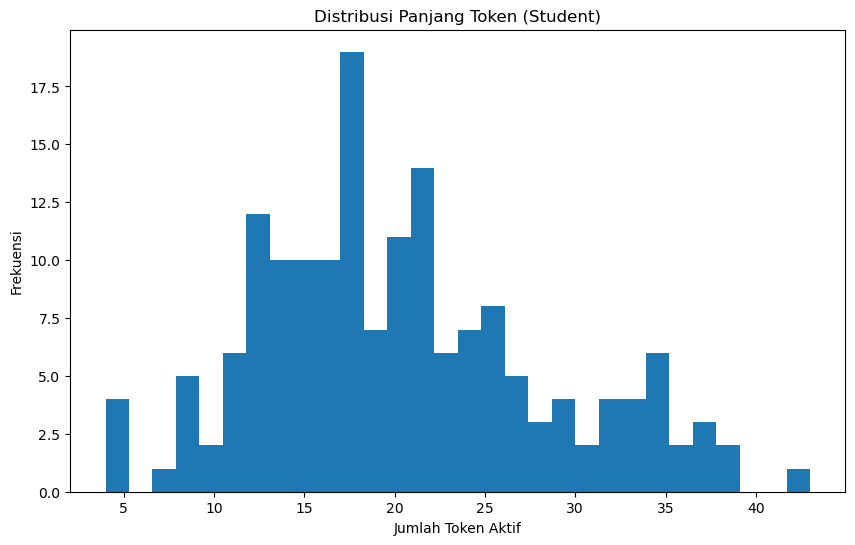

Rata-rata panjang token: 20.35
Persentase terpotong: 0.00%


In [106]:
# Memeriksa distribusi panjang token untuk memastikan max_length cukup
student_lengths = [sum(mask) for mask in student_tokens['attention_mask'].numpy()]
plt.figure(figsize=(10, 6))
plt.hist(student_lengths, bins=30)
plt.title('Distribusi Panjang Token (Student)')
plt.xlabel('Jumlah Token Aktif')
plt.ylabel('Frekuensi')
plt.show()
print(f"Rata-rata panjang token: {np.mean(student_lengths):.2f}")
print(f"Persentase terpotong: {sum(l == 128 for l in student_lengths) / len(student_lengths) * 100:.2f}%")

In [107]:
# Mendekode token untuk memastikan tokenisasi berfungsi dengan baik
sample_text = student_sentences[0]
sample_tokens = tokenizer.encode(sample_text)
print(f"Teks asli: {sample_text}")
print(f"Token ID: {sample_tokens}")
print(f"Token dekode: {tokenizer.decode(sample_tokens)}")

Teks asli: teknologi adalah segala sesuatu yang menciptakan efisiensi dan efektivitas untuk manusia.
Token ID: [2, 1429, 154, 1517, 1370, 34, 2800, 7630, 41, 11811, 90, 666, 30470, 3]
Token dekode: [CLS] teknologi adalah segala sesuatu yang menciptakan efisiensi dan efektivitas untuk manusia. [SEP]


In [96]:
# Jika tokenisasi memakan waktu lama, pertimbangkan untuk menyimpannya
tokenized_data = {
    'student': student_tokens,
    'chatgpt_1': chatgpt_tokens_1,
    'chatgpt_2': chatgpt_tokens_2
}

# Menyimpan input_ids dan attention_mask sebagai numpy arrays
tokenized_numpy = {
    'student': {
        'input_ids': student_tokens['input_ids'].numpy(),
        'attention_mask': student_tokens['attention_mask'].numpy()
    },
    'chatgpt_1': {
        'input_ids': chatgpt_tokens_1['input_ids'].numpy(),
        'attention_mask': chatgpt_tokens_1['attention_mask'].numpy()
    },
    'chatgpt_2': {
        'input_ids': chatgpt_tokens_2['input_ids'].numpy(),
        'attention_mask': chatgpt_tokens_2['attention_mask'].numpy()
    }
}

with open('tokenized_data.pkl', 'wb') as f:
    pickle.dump(tokenized_numpy, f)

## 8. Membuat Model BERT Bi-Encoder

Dua model Bi-Encoder dibuat:
- Bi-Encoder untuk Only_ChatGPT: Digunakan untuk memahami teks dari dataset Only_ChatGPT.
- Bi-Encoder untuk Student_ChatGPT: Digunakan untuk memahami interaksi antara Student dan ChatGPT.

Arsitektur Bi-Encoder melibatkan:
- IndoBERT sebagai backbone untuk menghasilkan embeddings.
- Dense Layers untuk fine-tuning.
- L2 Normalization untuk menghasilkan embeddings yang seragam.

In [ ]:
# Load model IndoBERT
bert_model = TFBertModel.from_pretrained("indobenchmark/indobert-base-p2")

# Freeze BERT layers
for layer in bert_model.layers:
    layer.trainable = False

# Fungsi untuk membuat Bi-Encoder
def build_bi_encoder(bert_model):
    """
    Membuat model Bi-Encoder dengan IndoBERT.
    
    Args:
        bert_model (TFBertModel): Model dasar IndoBERT.
        
    Returns:
        tf.keras.Model: Model Bi-Encoder.
    """
    # Input layer untuk token ID dan attention mask
    input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
    attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")
    
    # Extract CLS token embeddings dari IndoBERT
    bert_output = bert_model(input_ids, attention_mask=attention_mask)[0][:, 0, :]  # [CLS] token
    
    # Dense layer untuk fine-tuning
    dense1 = tf.keras.layers.Dense(128, activation="relu")(bert_output)
    dropout1 = tf.keras.layers.Dropout(0.1)(dense1)
    dense2 = tf.keras.layers.Dense(128, activation="relu")(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.1)(dense2)
    dense3 = tf.keras.layers.Dense(128)(dropout2)
    
    # Normalisasi output (L2 normalization)
    normalized_output = tf.nn.l2_normalize(dense3, axis=1)
    
    # Model Bi-Encoder
    return tf.keras.Model(inputs=[input_ids, attention_mask], outputs=normalized_output)

# Buat dua Bi-Encoder
bi_encoder_student_chatgpt = build_bi_encoder(bert_model)
bi_encoder_only_chatgpt = build_bi_encoder(bert_model)

# Tampilkan arsitektur
print("Bi-Encoder untuk Student_ChatGPT:")
bi_encoder_student_chatgpt.summary()

print("\nBi-Encoder untuk Student_ChatGPT:")
bi_encoder_student_chatgpt.summary()

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Bi-Encoder untuk Student_ChatGPT:
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_3 (TFBertMod  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7   

## 9. Constrastive Loss

Contrastive loss digunakan untuk melatih Bi-Encoder dengan tujuan:
- Pasangan kalimat yang mirip memiliki nilai similarity tinggi (loss rendah).
- Pasangan kalimat yang tidak mirip memiliki nilai similarity rendah (loss tinggi).

Datasets Student_ChatGPT: variable -> student_sentences & chatgpt_sentences_1
Pasangan Positif:
- Student - Student Dalam satu data, antar kalimat
- Student - Student Beda data, Antar kalimat
- ChatGPT - ChatGPT Dalam satu data, antar kalimat
- ChatGPT - ChatGPT Beda data, Antar kalimat

Pasangan Negatif:
- Student - ChatGPT Beda data, Antar kalimat

Datasets Only_ChatGPT: variable -> chatgpt_sentences_2
Pasangan Positif:
- ChatGPT - ChatGPT Dalam satu data, antar kalimat
- ChatGPT - ChatGPT Beda data, Antar kalimat

In [ ]:
def create_contrastive_pairs(student_tokens, chatgpt_tokens, max_pairs=None):
    """
    Membuat pasangan data untuk contrastive learning dengan jumlah yang menyesuaikan dataset.

    Args:
        student_tokens: Token dari teks student.
        chatgpt_tokens: Token dari teks ChatGPT.
        max_pairs: Jumlah maksimum pasangan (opsional). Jika None, akan menggunakan semua kombinasi yang mungkin.

    Returns:
        tuple: Pasangan anchor, positive, negative, dan label serta jumlah total pasangan.
    """
    # Import yang diperlukan
    import random

    # Jumlah data
    n_student = student_tokens['input_ids'].shape[0]
    n_chatgpt = chatgpt_tokens['input_ids'].shape[0]

    # Hitung jumlah pasangan yang mungkin
    max_student_pairs = (n_student * (n_student - 1)) // 2  # Kombinasi student-student
    max_chatgpt_pairs = (n_chatgpt * (n_chatgpt - 1)) // 2  # Kombinasi chatgpt-chatgpt
    max_negative_pairs = n_student * n_chatgpt  # Kombinasi student-chatgpt

    # Tentukan jumlah pasangan yang akan dibuat
    if max_pairs is None:
        # Gunakan jumlah minimum dari pasangan positif untuk keseimbangan
        n_pos_student = min(max_student_pairs, max_chatgpt_pairs) // 2
        n_pos_chatgpt = n_pos_student
        # Batasi jumlah pasangan negatif agar seimbang dengan positif
        n_neg_pairs = min(max_negative_pairs, 2 * n_pos_student)
        # Total pasangan
        total_pairs = 2 * n_pos_student + n_neg_pairs
    else:
        # Jika max_pairs ditentukan, gunakan itu dengan proporsi yang sama
        n_pos_student = max_pairs // 4
        n_pos_chatgpt = max_pairs // 4
        n_neg_pairs = max_pairs // 2
        total_pairs = max_pairs

    # Pastikan tidak melebihi jumlah maksimum yang mungkin
    n_pos_student = min(n_pos_student, max_student_pairs)
    n_pos_chatgpt = min(n_pos_chatgpt, max_chatgpt_pairs)
    n_neg_pairs = min(n_neg_pairs, max_negative_pairs)

    # Inisialisasi array untuk pasangan data
    anchor_input_ids = []
    anchor_attention_mask = []
    positive_input_ids = []
    positive_attention_mask = []
    negative_input_ids = []
    negative_attention_mask = []
    labels = []

    # Membuat pasangan positif (student-student)
    if n_pos_student > 0:
        # Buat semua kemungkinan pasangan indeks
        student_pairs = [(i, j) for i in range(n_student) for j in range(i+1, n_student)]
        # Acak dan ambil sebanyak yang diperlukan
        selected_pairs = random.sample(student_pairs, n_pos_student)

        for idx1, idx2 in selected_pairs:
            anchor_input_ids.append(student_tokens['input_ids'][idx1])
            anchor_attention_mask.append(student_tokens['attention_mask'][idx1])

            positive_input_ids.append(student_tokens['input_ids'][idx2])
            positive_attention_mask.append(student_tokens['attention_mask'][idx2])

            # Negative dari ChatGPT
            neg_idx = np.random.choice(n_chatgpt)
            negative_input_ids.append(chatgpt_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][neg_idx])

            labels.append(1)  # 1 untuk pasangan positif

    # Membuat pasangan positif (chatgpt-chatgpt)
    if n_pos_chatgpt > 0:
        # Buat semua kemungkinan pasangan indeks
        chatgpt_pairs = [(i, j) for i in range(n_chatgpt) for j in range(i+1, n_chatgpt)]
        # Acak dan ambil sebanyak yang diperlukan
        selected_pairs = random.sample(chatgpt_pairs, n_pos_chatgpt)

        for idx1, idx2 in selected_pairs:
            anchor_input_ids.append(chatgpt_tokens['input_ids'][idx1])
            anchor_attention_mask.append(chatgpt_tokens['attention_mask'][idx1])

            positive_input_ids.append(chatgpt_tokens['input_ids'][idx2])
            positive_attention_mask.append(chatgpt_tokens['attention_mask'][idx2])

            # Negative dari Student
            neg_idx = np.random.choice(n_student)
            negative_input_ids.append(student_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(student_tokens['attention_mask'][neg_idx])

            labels.append(1)  # 1 untuk pasangan positif

    # Membuat pasangan negatif (student-chatgpt)
    if n_neg_pairs > 0:
        # Buat semua kemungkinan pasangan indeks
        negative_pairs = [(i, j) for i in range(n_student) for j in range(n_chatgpt)]
        # Acak dan ambil sebanyak yang diperlukan
        selected_pairs = random.sample(negative_pairs, n_neg_pairs)

        for student_idx, chatgpt_idx in selected_pairs:
            anchor_input_ids.append(student_tokens['input_ids'][student_idx])
            anchor_attention_mask.append(student_tokens['attention_mask'][student_idx])

            negative_input_ids.append(chatgpt_tokens['input_ids'][chatgpt_idx])
            negative_attention_mask.append(chatgpt_tokens['attention_mask'][chatgpt_idx])

            # Positive dari Student (berbeda dengan anchor)
            available_pos = [i for i in range(n_student) if i != student_idx]
            if available_pos:  # Pastikan ada indeks yang tersedia
                pos_idx = np.random.choice(available_pos)
                positive_input_ids.append(student_tokens['input_ids'][pos_idx])
                positive_attention_mask.append(student_tokens['attention_mask'][pos_idx])

                labels.append(0)  # 0 untuk pasangan negatif

    # Hitung jumlah pasangan yang sebenarnya dibuat
    actual_pairs = len(labels)

    # Konversi ke tensor
    return {
        'anchor': {
            'input_ids': tf.convert_to_tensor(anchor_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(anchor_attention_mask, dtype=tf.int32)
        },
        'positive': {
            'input_ids': tf.convert_to_tensor(positive_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(positive_attention_mask, dtype=tf.int32)
        },
        'negative': {
            'input_ids': tf.convert_to_tensor(negative_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(negative_attention_mask, dtype=tf.int32)
        },
        'labels': tf.convert_to_tensor(labels, dtype=tf.float32)
    }, actual_pairs


In [ ]:
# Buat pasangan data untuk model Student_ChatGPT tanpa menentukan n_pairs
student_chatgpt_pairs, total_pairs = create_contrastive_pairs(student_tokens, chatgpt_tokens_1, max_pairs=5000)

# Tampilkan jumlah pasangan yang dibuat
print(f"Total contrastive pairs yang dibuat: {total_pairs}")
print(f"- Pasangan positif student-student: {sum(1 for label in student_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan positif chatgpt-chatgpt: {sum(1 for label in student_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan negatif student-chatgpt: {sum(1 for label in student_chatgpt_pairs['labels'].numpy() if label == 0)}")

# Jika ingin membatasi jumlah maksimum pasangan
# student_chatgpt_pairs, total_pairs = create_contrastive_pairs(student_tokens, chatgpt_tokens_1, max_pairs=1000)

Total contrastive pairs yang dibuat: 31152
- Pasangan positif student-student: 7788
- Pasangan positif chatgpt-chatgpt: 7788
- Pasangan negatif student-chatgpt: 15576


In [ ]:
# Implementasi contrastive loss
def contrastive_loss(y_true, y_pred):
    """
    Contrastive loss untuk triplet (anchor, positive, negative).
    
    Args:
        y_true: Label (1 untuk pasangan positif, 0 untuk pasangan negatif).
        y_pred: Jarak antara anchor-positive dan anchor-negative.
        
    Returns:
        tf.Tensor: Nilai loss.
    """
    margin = 0.5
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

In [ ]:
# Model untuk training dengan triplet loss
def build_triplet_model(bi_encoder):
    """
    Membangun model untuk training dengan triplet loss.
    
    Args:
        bi_encoder: Model bi-encoder yang akan dilatih.
        
    Returns:
        tf.keras.Model: Model untuk training dengan triplet loss.
    """
    # Input untuk anchor, positive, dan negative
    anchor_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="anchor_input_ids")
    anchor_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="anchor_attention_mask")

    positive_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="positive_input_ids")
    positive_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="positive_attention_mask")
    
    negative_input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="negative_input_ids")
    negative_attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="negative_attention_mask")
    
    # Embedding untuk anchor, positive, dan negative
    anchor_embedding = bi_encoder([anchor_input_ids, anchor_attention_mask])
    positive_embedding = bi_encoder([positive_input_ids, positive_attention_mask])
    negative_embedding = bi_encoder([negative_input_ids, negative_attention_mask])
    
    # Hitung cosine similarity
    pos_similarity = tf.reduce_sum(anchor_embedding * positive_embedding, axis=1)
    neg_similarity = tf.reduce_sum(anchor_embedding * negative_embedding, axis=1)
    
    # Output model adalah perbedaan similarity
    output = tf.stack([pos_similarity, neg_similarity], axis=1)
    
    return tf.keras.Model(
        inputs=[
            anchor_input_ids, anchor_attention_mask,
            positive_input_ids, positive_attention_mask,
            negative_input_ids, negative_attention_mask
        ],
        outputs=output
    )

In [ ]:
# Buat model triplet untuk Student_ChatGPT
triplet_model_student_chatgpt = build_triplet_model(bi_encoder_student_chatgpt)

# Custom loss function untuk triplet
def triplet_loss(y_true, y_pred):
    """
    Triplet loss: mendorong similarity positif lebih tinggi dari similarity negatif.
    
    Args:
        y_true: Tidak digunakan dalam triplet loss.
        y_pred: Stack dari [positive_similarity, negative_similarity].
        
    Returns:
        tf.Tensor: Nilai loss.
    """
    pos_sim = y_pred[:, 0]
    neg_sim = y_pred[:, 1]
    margin = 0.5
    
    # Triplet loss: max(0, margin - (pos_sim - neg_sim))
    loss = tf.maximum(0., margin - (pos_sim - neg_sim))
    return tf.reduce_mean(loss)

## 10. Train Bi-Encoder

Kedua Bi-Encoder dilatih secara terpisah:
1. Only_ChatGPT:
- Pasangan positif: Kalimat yang saling berdekatan dalam satu bab.
2. Student_ChatGPT:
- Pasangan positif: Student dan ChatGPT untuk soal yang sama.
- Pasangan negatif: Student dengan Student atau ChatGPT dengan ChatGPT.

Hasil pelatihan divisualisasikan untuk memantau performa loss selama training dan validation.

### 10.2. Training Student - ChatGPT

In [ ]:
# Compile model
triplet_model_student_chatgpt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Student_ChatGPT
print("Training Bi-Encoder untuk Student_ChatGPT...")
history_student_chatgpt = triplet_model_student_chatgpt.fit(
    x=[
        student_chatgpt_pairs['anchor']['input_ids'],
        student_chatgpt_pairs['anchor']['attention_mask'],
        student_chatgpt_pairs['positive']['input_ids'],
        student_chatgpt_pairs['positive']['attention_mask'],
        student_chatgpt_pairs['negative']['input_ids'],
        student_chatgpt_pairs['negative']['attention_mask']
    ],
    y=student_chatgpt_pairs['labels'],  # Tidak digunakan dalam triplet loss
    epochs=3,
    batch_size=32,
    validation_split=0.3,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

### 10.3. Training Only ChatGPT

In [ ]:
def create_contrastive_pairs_2(student_tokens, chatgpt_tokens_1, chatgpt_tokens_2, max_pairs=None):
    """
    Membuat pasangan data untuk contrastive learning dengan jumlah yang menyesuaikan dataset.

    Args:
        student_tokens: Token dari teks student.
        chatgpt_tokens: Token dari teks ChatGPT.
        max_pairs: Jumlah maksimum pasangan (opsional). Jika None, akan menggunakan semua kombinasi yang mungkin.

    Returns:
        tuple: Pasangan anchor, positive, negative, dan label serta jumlah total pasangan.
    """

    # Jumlah data
    n_student = student_tokens['input_ids'].shape[0]
    n_chatgpt_1 = chatgpt_tokens_1['input_ids'].shape[0]
    n_chatgpt_2 = chatgpt_tokens_2['input_ids'].shape[0]

    # Hitung jumlah pasangan yang mungkin
    max_student_pairs = (n_student * (n_student - 1)) // 2  # Kombinasi student-student
    max_chatgpt_pairs = (n_chatgpt_1 * (n_chatgpt_1 - 1)) // 2  # Kombinasi chatgpt-chatgpt
    max_negative_pairs = n_student * n_chatgpt_2  # Kombinasi student-chatgpt

    # Tentukan jumlah pasangan yang akan dibuat
    if max_pairs is None:
        # Gunakan jumlah minimum dari pasangan positif untuk keseimbangan
        n_pos_student = min(max_student_pairs, max_chatgpt_pairs) // 2
        n_pos_chatgpt = n_pos_student
        # Batasi jumlah pasangan negatif agar seimbang dengan positif
        n_neg_pairs = min(max_negative_pairs, 2 * n_pos_student)
        # Total pasangan
        total_pairs = 2 * n_pos_student + n_neg_pairs
    else:
        # Jika max_pairs ditentukan, gunakan itu dengan proporsi yang sama
        n_pos_student = max_pairs // 4
        n_pos_chatgpt = max_pairs // 4
        n_neg_pairs = max_pairs // 2
        total_pairs = max_pairs

    # Pastikan tidak melebihi jumlah maksimum yang mungkin
    n_pos_student = min(n_pos_student, max_student_pairs)
    n_pos_chatgpt = min(n_pos_chatgpt, max_chatgpt_pairs)
    n_neg_pairs = min(n_neg_pairs, max_negative_pairs)

    # Inisialisasi array untuk pasangan data
    anchor_input_ids = []
    anchor_attention_mask = []
    positive_input_ids = []
    positive_attention_mask = []
    negative_input_ids = []
    negative_attention_mask = []
    labels = []

    # Membuat pasangan positif (student-student)
    if n_pos_student > 0:
        # Buat semua kemungkinan pasangan indeks
        student_pairs = [(i, j) for i in range(n_student) for j in range(i+1, n_student)]
        # Acak dan ambil sebanyak yang diperlukan
        selected_pairs = random.sample(student_pairs, n_pos_student)

        for idx1, idx2 in selected_pairs:
            anchor_input_ids.append(student_tokens['input_ids'][idx1])
            anchor_attention_mask.append(student_tokens['attention_mask'][idx1])

            positive_input_ids.append(student_tokens['input_ids'][idx2])
            positive_attention_mask.append(student_tokens['attention_mask'][idx2])

            # Negative dari ChatGPT
            neg_idx = np.random.choice(n_chatgpt_2)
            negative_input_ids.append(chatgpt_tokens_2['input_ids'][neg_idx])
            negative_attention_mask.append(chatgpt_tokens_2['attention_mask'][neg_idx])

            labels.append(1)  # 1 untuk pasangan positif

    # Membuat pasangan positif (chatgpt-chatgpt)
    if n_pos_chatgpt > 0:
        # Buat semua kemungkinan pasangan indeks
        chatgpt_pairs = [(i, j) for i in range(n_chatgpt_1) for j in range(i+1, n_chatgpt_1)]
        # Acak dan ambil sebanyak yang diperlukan
        selected_pairs = random.sample(chatgpt_pairs, n_pos_chatgpt)

        for idx1, idx2 in selected_pairs:
            anchor_input_ids.append(chatgpt_tokens_1['input_ids'][idx1])
            anchor_attention_mask.append(chatgpt_tokens_1['attention_mask'][idx1])

            positive_input_ids.append(chatgpt_tokens_2['input_ids'][idx2])
            positive_attention_mask.append(chatgpt_tokens_2['attention_mask'][idx2])

            # Negative dari Student
            neg_idx = np.random.choice(n_student)
            negative_input_ids.append(student_tokens['input_ids'][neg_idx])
            negative_attention_mask.append(student_tokens['attention_mask'][neg_idx])

            labels.append(1)  # 1 untuk pasangan positif

    # Membuat pasangan negatif (student-chatgpt)
    if n_neg_pairs > 0:
        # Buat semua kemungkinan pasangan indeks
        negative_pairs = [(i, j) for i in range(n_student) for j in range(n_chatgpt_2)]
        # Acak dan ambil sebanyak yang diperlukan
        selected_pairs = random.sample(negative_pairs, n_neg_pairs)

        for student_idx, chatgpt_idx in selected_pairs:
            anchor_input_ids.append(student_tokens['input_ids'][student_idx])
            anchor_attention_mask.append(student_tokens['attention_mask'][student_idx])

            negative_input_ids.append(chatgpt_tokens_2['input_ids'][chatgpt_idx])
            negative_attention_mask.append(chatgpt_tokens_2['attention_mask'][chatgpt_idx])

            # Positive dari Student (berbeda dengan anchor)
            available_pos = [i for i in range(n_student) if i != student_idx]
            if available_pos:  # Pastikan ada indeks yang tersedia
                pos_idx = np.random.choice(available_pos)
                positive_input_ids.append(student_tokens['input_ids'][pos_idx])
                positive_attention_mask.append(student_tokens['attention_mask'][pos_idx])

                labels.append(0)  # 0 untuk pasangan negatif

    # Hitung jumlah pasangan yang sebenarnya dibuat
    actual_pairs = len(labels)

    # Konversi ke tensor
    return {
        'anchor': {
            'input_ids': tf.convert_to_tensor(anchor_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(anchor_attention_mask, dtype=tf.int32)
        },
        'positive': {
            'input_ids': tf.convert_to_tensor(positive_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(positive_attention_mask, dtype=tf.int32)
        },
        'negative': {
            'input_ids': tf.convert_to_tensor(negative_input_ids, dtype=tf.int32),
            'attention_mask': tf.convert_to_tensor(negative_attention_mask, dtype=tf.int32)
        },
        'labels': tf.convert_to_tensor(labels, dtype=tf.float32)
    }, actual_pairs


In [ ]:
# Buat pasangan data untuk model Only_ChatGPT tanpa menentukan n_pairs
only_chatgpt_pairs, total_pairs = create_contrastive_pairs_2(student_tokens, chatgpt_tokens_1, chatgpt_tokens_2, max_pairs=5000)

# Tampilkan jumlah pasangan yang dibuat
print(f"Total Knowledge GPT pairs yang dibuat: {total_pairs}")
print(f"- Pasangan positif student-student: {sum(1 for label in only_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan positif chatgpt-chatgpt: {sum(1 for label in only_chatgpt_pairs['labels'].numpy() if label == 1)//2}")
print(f"- Pasangan negatif student-chatgpt: {sum(1 for label in only_chatgpt_pairs['labels'].numpy() if label == 0)}")

# Jika ingin membatasi jumlah maksimum pasangan
# only_chatgpt_pairs, total_pairs = create_self_supervised_pairs(chatgpt_tokens_2, max_pairs=1000)

In [ ]:
# Buat model triplet untuk Only_ChatGPT
triplet_model_only_chatgpt = build_triplet_model(bi_encoder_only_chatgpt)

# Compile model
triplet_model_only_chatgpt.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=triplet_loss
)

# Training model Only_ChatGPT
print("Training Bi-Encoder untuk Only_ChatGPT...")
history_only_chatgpt = triplet_model_only_chatgpt.fit(
    x=[
        only_chatgpt_pairs['anchor']['input_ids'],
        only_chatgpt_pairs['anchor']['attention_mask'],
        only_chatgpt_pairs['positive']['input_ids'],
        only_chatgpt_pairs['positive']['attention_mask'],
        only_chatgpt_pairs['negative']['input_ids'],
        only_chatgpt_pairs['negative']['attention_mask']
    ],
    y=only_chatgpt_pairs['labels'],  # Tidak digunakan dalam triplet loss
    epochs=3,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
    ]
)

### 10.4. Training History

In [ ]:
# Plot training history untuk model Student_ChatGPT
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_student_chatgpt.history['loss'], label='Training Loss')
plt.plot(history_student_chatgpt.history['val_loss'], label='Validation Loss')
plt.title('Model Student_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training history untuk model Only_ChatGPT
plt.subplot(1, 2, 2)
plt.plot(history_only_chatgpt.history['loss'], label='Training Loss')
plt.plot(history_only_chatgpt.history['val_loss'], label='Validation Loss')
plt.title('Model Only_ChatGPT: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 11. Evaluasi Bi-Encoder

Bi-Encoder dievaluasi dengan menghitung cosine similarity antara embeddings yang dihasilkan:
- Student vs ChatGPT (Student_ChatGPT).
- ChatGPT (Student_ChatGPT) vs ChatGPT (Only_ChatGPT).

Similarity score digunakan untuk memahami seberapa dekat embeddings dari berbagai sumber teks.

In [ ]:
# Fungsi untuk menghasilkan embeddings
def generate_embeddings(tokens, model):
    """
    Menghasilkan embeddings untuk teks.
    
    Args:
        tokens: Token dari teks.
        model: Model bi-encoder.
        
    Returns:
        tf.Tensor: Embeddings.
    """
    return model([tokens['input_ids'], tokens['attention_mask']])

In [ ]:
# Fungsi untuk menghitung similarity score dengan agregasi maksimum
def compute_similarity_max(embedding1, embedding2):
    """
    Menghitung similarity score dengan metode agregasi maksimum.
    
    Args:
        embedding1: Embedding pertama (teks input).
        embedding2: Embedding kedua (referensi).
        
    Returns:
        float: Similarity score maksimum.
    """
    # Normalisasi embeddings (L2 norm)
    embedding1_norm = tf.nn.l2_normalize(embedding1, axis=-1)
    embedding2_norm = tf.nn.l2_normalize(embedding2, axis=-1)
    
    # Hitung cosine similarity
    similarities = tf.matmul(embedding1_norm, tf.transpose(embedding2_norm))
    similarities = tf.reshape(similarities, [-1])  # Flatten
    
    # Ambil nilai maksimum
    max_similarity = tf.reduce_max(similarities).numpy()
    return max_similarity

In [ ]:
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Simpan model bi-encoder untuk Student_ChatGPT
bi_encoder_student_chatgpt.save('saved_models/bi_encoder_student_chatgpt.h5')

# Simpan model bi-encoder untuk Only_ChatGPT
bi_encoder_only_chatgpt.save('saved_models/bi_encoder_only_chatgpt.h5')

# Save tokenizer configuration
tokenizer.save_pretrained('saved_models/tokenizer')

In [ ]:
custom_objects = {'TFBertModel': TFBertModel}

with tf.keras.utils.custom_object_scope(custom_objects):
    # Muat model bi-encoder yang sudah dilatih
    bi_encoder_student_chatgpt = tf.keras.models.load_model('saved_models_v2/bi_encoder_student_chatgpt.h5')
    bi_encoder_only_chatgpt = tf.keras.models.load_model('saved_models_v2/bi_encoder_only_chatgpt.h5')

In [ ]:
# Inisialisasi tokenizer IndoBERT
tokenizer = BertTokenizer.from_pretrained('saved_models_v2/tokenizer')

# Fungsi untuk tokenisasi teks
def tokenize_text(texts, max_length=128):
    """
    Tokenisasi teks menggunakan tokenizer IndoBERT.
    
    Args:
        texts (list): Daftar teks yang akan di-tokenisasi.
        max_length (int): Panjang maksimum token.
        
    Returns:
        dict: Token hasil tokenisasi, termasuk input_ids dan attention_mask.
    """
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )

In [ ]:
# Tokenisasi data
print("Tokenisasi kalimat Student...")
student_tokens = tokenize_text(student_sentences)

print("Tokenisasi kalimat ChatGPT (Student_ChatGPT)...")
chatgpt_tokens_1 = tokenize_text(chatgpt_sentences_1)

print("Tokenisasi kalimat ChatGPT (Only_ChatGPT)...")
chatgpt_tokens_2 = tokenize_text(chatgpt_sentences_2)

# Tampilkan hasil tokenisasi (contoh: Student)
print("\nContoh hasil tokenisasi:")
print(student_tokens['input_ids'][:1])  # Input token ID
print(student_tokens['attention_mask'][:1])  # Attention mask

In [ ]:
# Generate embeddings untuk semua data
print("Generating embeddings for Student...")
student_embeddings_1 = generate_embeddings(student_tokens, bi_encoder_student_chatgpt)
print("Generating embeddings for ChatGPT (Student_ChatGPT)...")
chatgpt_embeddings_1 = generate_embeddings(chatgpt_tokens_1, bi_encoder_student_chatgpt)
print("Generating embeddings for ChatGPT (Only_ChatGPT)...")
chatgpt_embeddings_2 = generate_embeddings(chatgpt_tokens_2, bi_encoder_only_chatgpt)

# Cari jumlah pasangan yang paling sedikit
min_pairs = min(
    student_embeddings_1.shape[0],
    chatgpt_embeddings_1.shape[0],
    chatgpt_embeddings_2.shape[0]
)

# Cari jumlah pasangan yang paling sedikit
min_pairs = min(
    student_embeddings_1.shape[0],
    chatgpt_embeddings_1.shape[0],
    chatgpt_embeddings_2.shape[0]
)

# Pilih secara acak untuk keadilan
np.random.seed(42)
random_indices_student = np.random.choice(student_embeddings_1.shape[0], size=min_pairs, replace=False)
random_indices_chatgpt1 = np.random.choice(chatgpt_embeddings_1.shape[0], size=min_pairs, replace=False)
random_indices_chatgpt2 = np.random.choice(chatgpt_embeddings_2.shape[0], size=min_pairs, replace=False)

# Convert NumPy indices to TensorFlow tensors
random_indices_student_tf = tf.constant(random_indices_student, dtype=tf.int32)
random_indices_chatgpt1_tf = tf.constant(random_indices_chatgpt1, dtype=tf.int32)
random_indices_chatgpt2_tf = tf.constant(random_indices_chatgpt2, dtype=tf.int32)

# Potong array agar jumlah pasangan berimbang - using tf.gather
student_emb1_balanced = tf.gather(student_embeddings_1, random_indices_student_tf)
chatgpt1_emb1_balanced = tf.gather(chatgpt_embeddings_1, random_indices_chatgpt1_tf)
chatgpt2_emb2_balanced = tf.gather(chatgpt_embeddings_2, random_indices_chatgpt2_tf)

In [ ]:
# 1. Similarity dengan Student (dari model Student_ChatGPT)
student_student_sim_scores = []
student_gpt1_sim_scores = []
student_gpt2_sim_scores = []
for emb in student_embeddings_1:
    max_similarity = compute_similarity_max(tf.expand_dims(emb, 0), student_embeddings_1)
    student_student_sim_scores.append(max_similarity)

    max_similarity = compute_similarity_max(tf.expand_dims(emb, 0), chatgpt_embeddings_1)
    student_gpt1_sim_scores.append(max_similarity)

    max_similarity = compute_similarity_max(tf.expand_dims(emb, 0), chatgpt_embeddings_2)
    student_gpt2_sim_scores.append(max_similarity)


# 2. Similarity dengan ChatGPT (dari model Student_ChatGPT)
gpt1_student_sim_scores = []
gpt1_gpt1_sim_scores = []
gpt1_gpt2_sim_scores = []
for emb in chatgpt_embeddings_1:
    max_similarity = compute_similarity_max(tf.expand_dims(emb, 0), student_embeddings_1)
    gpt1_student_sim_scores.append(max_similarity)

    max_similarity = compute_similarity_max(tf.expand_dims(emb, 0), chatgpt_embeddings_1)
    gpt1_gpt1_sim_scores.append(max_similarity)

    max_similarity = compute_similarity_max(tf.expand_dims(emb, 0), chatgpt_embeddings_2)
    gpt1_gpt2_sim_scores.append(max_similarity)

# 3. Similarity dengan ChatGPT Knowledge (dari model Only_ChatGPT)
gpt2_student_sim_scores = []
gpt2_gpt1_sim_scores = []
gpt2_gpt2_sim_scores =[]
desired_count = len(student_embeddings_1)
np.random.seed(42)
random_indices = np.random.choice(len(chatgpt_embeddings_2), size=desired_count, replace=False)
for idx in random_indices:
    emb = chatgpt_embeddings_2[idx]
    max_similarity = compute_similarity_max(tf.expand_dims(emb, 0), student_embeddings_1)
    gpt2_student_sim_scores.append(max_similarity)

    max_similarity = compute_similarity_max(tf.expand_dims(emb, 0), chatgpt_embeddings_1)
    gpt2_gpt1_sim_scores.append(max_similarity)

    max_similarity = compute_similarity_max(tf.expand_dims(emb, 0), chatgpt_embeddings_2)
    gpt2_gpt2_sim_scores.append(max_similarity)

# Konversi ke numpy arrays
student_similarity_scores = np.array([student_student_sim_scores, student_gpt1_sim_scores, student_gpt2_sim_scores])
chatgpt1_similarity_scores = np.array([gpt1_student_sim_scores, gpt1_gpt1_sim_scores, gpt1_gpt2_sim_scores])
chatgpt2_similarity_scores = np.array([gpt2_student_sim_scores, gpt2_gpt1_sim_scores, gpt2_gpt2_sim_scores])

# Hitung jumlah similarity scores untuk masing-masing kategori
num_student_scores = student_similarity_scores.size
num_chatgpt1_scores = chatgpt1_similarity_scores.size
num_chatgpt2_scores = chatgpt2_similarity_scores.size

# Tampilkan hasil
print(f"Jumlah similarity scores untuk Student (balanced): {num_student_scores}")
print(f"Jumlah similarity scores untuk ChatGPT1(balanced): {num_chatgpt1_scores}")
print(f"Jumlah similarity scores untuk ChatGPT2(balanced): {num_chatgpt2_scores}")

# Cari jumlah pasangan yang paling sedikit
min_pairs = min(
    student_similarity_scores.shape[1],
    chatgpt1_similarity_scores.shape[1],
    chatgpt2_similarity_scores.shape[1]
)

# Pilih secara acak untuk keadilan
np.random.seed(42)
random_indices_student = np.random.choice(student_similarity_scores.shape[1], size=min_pairs, replace=False)
random_indices_chatgpt1 = np.random.choice(chatgpt1_similarity_scores.shape[1], size=min_pairs, replace=False)
random_indices_chatgpt2 = np.random.choice(chatgpt2_similarity_scores.shape[1], size=min_pairs, replace=False)

# Potong array agar jumlah pasangan berimbang
student_similarity_scores_balanced = student_similarity_scores[:, random_indices_student]
chatgpt1_similarity_scores_balanced = chatgpt1_similarity_scores[:, random_indices_chatgpt1]
chatgpt2_similarity_scores_balanced = chatgpt2_similarity_scores[:, random_indices_chatgpt2]
# Tampilkan hasil
print(f"Jumlah pasangan setelah penyeimbangan: {min_pairs}")

# Hitung jumlah similarity scores untuk masing-masing kategori
num_student_scores_balanced = student_similarity_scores_balanced.size
num_chatgpt1_scores_balanced = chatgpt1_similarity_scores_balanced.size
num_chatgpt2_scores_balanced = chatgpt2_similarity_scores_balanced.size

# Tampilkan hasil
print(f"Jumlah similarity scores untuk Student (balanced): {num_student_scores_balanced}")
print(f"Jumlah similarity scores untuk ChatGPT1(balanced): {num_chatgpt1_scores_balanced}")
print(f"Jumlah similarity scores untuk ChatGPT2(balanced): {num_chatgpt2_scores_balanced}")

# Simpan similarity scores untuk digunakan dalam klasifikasi
reference_embeddings_1 = {
    'student': {
        'embeddings': student_embeddings_1.numpy(),
        'similarity_scores': student_similarity_scores_balanced
    },
    'chatgpt': {
        'embeddings': chatgpt_embeddings_1.numpy(),
        'similarity_scores': chatgpt1_similarity_scores_balanced
    }
}

reference_embeddings_2 = {
    'chatgpt_knowledge': {
        'embeddings': chatgpt_embeddings_2.numpy(),
        'similarity_scores': chatgpt2_similarity_scores_balanced
    }
}

In [ ]:
with open('saved_models/reference_embeddings_1.pkl', 'wb') as f:
    pickle.dump(reference_embeddings_1, f)

with open('saved_models/reference_embeddings_2.pkl', 'wb') as f:
    pickle.dump(reference_embeddings_2, f)

print("Reference embeddings saved successfully!")

In [ ]:
def extract_stylometric_features(text):
    """
    Ekstraksi fitur stylometric dari teks:
    - Panjang kata rata-rata
    - Rasio kata unik
    - Rasio tanda baca
    - Panjang kalimat
    - Variasi panjang kata
    - Rasio kata fungsi
    - Jumlah koma
    - Jumlah titik

    Args:
        text (str): Input teks.

    Returns:
        dict: Fitur stylometric.
    """
    # Tokenisasi kata dan kalimat
    words = re.findall(r'\b\w+\b', text)  # Token kata
    sentences = re.split(r'[.!?]', text)  # Token kalimat

    # Basic features
    n_chars = len(text)
    n_words = len(words)
    avg_word_length = np.mean([len(word) for word in words]) if n_words > 0 else 0
    unique_word_ratio = len(set(words)) / n_words if n_words > 0 else 0

    # Syntactic features
    punctuation_count = len(re.findall(r'[.,!?;:]', text))
    punctuation_ratio = punctuation_count / n_chars if n_chars > 0 else 0

    # Variasi panjang kata
    word_length_std = np.std([len(word) for word in words]) if n_words > 0 else 0

    # Rasio kata fungsi
    function_words = {'a','ada','adalah','adanya','adapun','agak','agaknya','agar','akan','akankah','akhir',
            'akhiri','akhirnya','aku','akulah','amat','amatlah','anda','andalah','antar','antara',
            'antaranya','apa','apaan','apabila','apakah','apalagi','apatah','arti','artinya','asal',
            'asalkan','atas','atau','ataukah','ataupun','awal','awalnya','b','bagai','bagaikan',
            'bagaimana','bagaimanakah','bagaimanapun','bagainamakah','bagi','bagian','bahkan','bahwa',
            'bahwasannya','bahwasanya','baik','baiklah','bakal','bakalan','balik','banyak','bapak',
            'baru','bawah','beberapa','begini','beginian','beginikah','beginilah','begitu','begitukah',
            'begitulah','begitupun','bekerja','belakang','belakangan','belum','belumlah','benar',
            'benarkah','benarlah','berada','berakhir','berakhirlah','berakhirnya','berapa','berapakah',
            'berapalah','berapapun','berarti','berawal','berbagai','berdatangan','beri','berikan',
            'berikut','berikutnya','berjumlah','berkali-kali','berkata','berkehendak','berkeinginan',
            'berkenaan','berlainan','berlalu','berlangsung','berlebihan','bermacam','bermacam-macam',
            'bermaksud','bermula','bersama','bersama-sama','bersiap','bersiap-siap','bertanya',
            'bertanya-tanya','berturut','berturut-turut','bertutur','berujar','berupa','besar',
            'betul','betulkah','biasa','biasanya','bila','bilakah','bisa','bisakah','boleh','bolehkah',
            'bolehlah','buat','bukan','bukankah','bukanlah','bukannya','bulan','bung','c','cara',
            'caranya','cukup','cukupkah','cukuplah','cuma','d','dahulu','dalam','dan','dapat','dari',
            'daripada','datang','dekat','demi','demikian','demikianlah','dengan','depan','di','dia',
            'diakhiri','diakhirinya','dialah','diantara','diantaranya','diberi','diberikan','diberikannya',
            'dibuat','dibuatnya','didapat','didatangkan','digunakan','diibaratkan','diibaratkannya',
            'diingat','diingatkan','diinginkan','dijawab','dijelaskan','dijelaskannya','dikarenakan',
            'dikatakan','dikatakannya','dikerjakan','diketahui','diketahuinya','dikira','dilakukan',
            'dilalui','dilihat','dimaksud','dimaksudkan','dimaksudkannya','dimaksudnya','diminta',
            'dimintai','dimisalkan','dimulai','dimulailah','dimulainya','dimungkinkan','dini','dipastikan',
            'diperbuat','diperbuatnya','dipergunakan','diperkirakan','diperlihatkan','diperlukan',
            'diperlukannya','dipersoalkan','dipertanyakan','dipunyai','diri','dirinya','disampaikan',
            'disebut','disebutkan','disebutkannya','disini','disinilah','ditambahkan','ditandaskan',
            'ditanya','ditanyai','ditanyakan','ditegaskan','ditujukan','ditunjuk','ditunjuki','ditunjukkan',
            'ditunjukkannya','ditunjuknya','dituturkan','dituturkannya','diucapkan','diucapkannya',
            'diungkapkan','dong','dua','dulu','e','empat','enak','enggak','enggaknya','entah','entahlah',
            'f','g','guna','gunakan','h','hadap','hai','hal','halo','hallo','hampir','hanya','hanyalah',
            'hari','harus','haruslah','harusnya','helo','hello','hendak','hendaklah','hendaknya','hingga',
            'i','ia','ialah','ibarat','ibaratkan','ibaratnya','ibu','ikut','ingat','ingat-ingat','ingin',
            'inginkah','inginkan','ini','inikah','inilah','itu','itukah','itulah','j','jadi','jadilah',
            'jadinya','jangan','jangankan','janganlah','jauh','jawab','jawaban','jawabnya','jelas',
            'jelaskan','jelaslah','jelasnya','jika','jikalau','juga','jumlah','jumlahnya','justru',
            'k','kadar','kala','kalau','kalaulah','kalaupun','kali','kalian','kami','kamilah','kamu',
            'kamulah','kan','kapan','kapankah','kapanpun','karena','karenanya','kasus','kata','katakan',
            'katakanlah','katanya','ke','keadaan','kebetulan','kecil','kedua','keduanya','keinginan',
            'kelamaan','kelihatan','kelihatannya','kelima','keluar','kembali','kemudian','kemungkinan',
            'kemungkinannya','kena','kenapa','kepada','kepadanya','kerja','kesampaian','keseluruhan',
            'keseluruhannya','keterlaluan','ketika','khusus','khususnya','kini','kinilah','kira',
            'kira-kira','kiranya','kita','kitalah','kok','kurang','l','lagi','lagian','lah','lain',
            'lainnya','laku','lalu','lama','lamanya','langsung','lanjut','lanjutnya','lebih','lewat',
            'lihat','lima','luar','m','macam','maka','makanya','makin','maksud','malah','malahan',
            'mampu','mampukah','mana','manakala','manalagi','masa','masalah','masalahnya','masih',
            'masihkah','masing','masing-masing','masuk','mata','mau','maupun','melainkan','melakukan',
            'melalui','melihat','melihatnya','memang','memastikan','memberi','memberikan','membuat',
            'memerlukan','memihak','meminta','memintakan','memisalkan','memperbuat','mempergunakan',
            'memperkirakan','memperlihatkan','mempersiapkan','mempersoalkan','mempertanyakan','mempunyai',
            'memulai','memungkinkan','menaiki','menambahkan','menandaskan','menanti','menanti-nanti',
            'menantikan','menanya','menanyai','menanyakan','mendapat','mendapatkan','mendatang','mendatangi',
            'mendatangkan','menegaskan','mengakhiri','mengapa','mengatakan','mengatakannya','mengenai',
            'mengerjakan','mengetahui','menggunakan','menghendaki','mengibaratkan','mengibaratkannya',
            'mengingat','mengingatkan','menginginkan','mengira','mengucapkan','mengucapkannya','mengungkapkan',
            'menjadi','menjawab','menjelaskan','menuju','menunjuk','menunjuki','menunjukkan','menunjuknya',
            'menurut','menuturkan','menyampaikan','menyangkut','menyatakan','menyebutkan','menyeluruh',
            'menyiapkan','merasa','mereka','merekalah','merupakan','meski','meskipun','meyakini','meyakinkan',
            'minta','mirip','misal','misalkan','misalnya','mohon','mula','mulai','mulailah','mulanya','mungkin',
            'mungkinkah','n','nah','naik','namun','nanti','nantinya','nya','nyaris','nyata','nyatanya',
            'o','oleh','olehnya','orang','p','pada','padahal','padanya','pak','paling','panjang','pantas',
            'para','pasti','pastilah','penting','pentingnya','per','percuma','perlu','perlukah','perlunya',
            'pernah','persoalan','pertama','pertama-tama','pertanyaan','pertanyakan','pihak','pihaknya',
            'pukul','pula','pun','punya','q','r','rasa','rasanya','rupa','rupanya','s','saat','saatnya','saja',
            'sajalah','salam','saling','sama','sama-sama','sambil','sampai','sampai-sampai','sampaikan','sana',
            'sangat','sangatlah','sangkut','satu','saya','sayalah','se','sebab','sebabnya','sebagai',
            'sebagaimana','sebagainya','sebagian','sebaik','sebaik-baiknya','sebaiknya','sebaliknya',
            'sebanyak','sebegini','sebegitu','sebelum','sebelumnya','sebenarnya','seberapa','sebesar',
            'sebetulnya','sebisanya','sebuah','sebut','sebutlah','sebutnya','secara','secukupnya','sedang',
            'sedangkan','sedemikian','sedikit','sedikitnya','seenaknya','segala','segalanya','segera',
            'seharusnya','sehingga','seingat','sejak','sejauh','sejenak','sejumlah','sekadar','sekadarnya',
            'sekali','sekali-kali','sekalian','sekaligus','sekalipun','sekarang','sekaranglah','sekecil',
            'seketika','sekiranya','sekitar','sekitarnya','sekurang-kurangnya','sekurangnya','sela','selain',
            'selaku','selalu','selama','selama-lamanya','selamanya','selanjutnya','seluruh','seluruhnya',
            'semacam','semakin','semampu','semampunya','semasa','semasih','semata','semata-mata','semaunya',
            'sementara','semisal','semisalnya','sempat','semua','semuanya','semula','sendiri','sendirian',
            'sendirinya','seolah','seolah-olah','seorang','sepanjang','sepantasnya','sepantasnyalah',
            'seperlunya','seperti','sepertinya','sepihak','sering','seringnya','serta','serupa','sesaat',
            'sesama','sesampai','sesegera','sesekali','seseorang','sesuatu','sesuatunya','sesudah',
            'sesudahnya','setelah','setempat','setengah','seterusnya','setiap','setiba','setibanya',
            'setidak-tidaknya','setidaknya','setinggi','seusai','sewaktu','siap','siapa','siapakah',
            'siapapun','sini','sinilah','soal','soalnya','suatu','sudah','sudahkah','sudahlah','supaya',
            't','tadi','tadinya','tahu','tak','tambah','tambahnya','tampak','tampaknya','tandas','tandasnya',
            'tanpa','tanya','tanyakan','tanyanya','tapi','tegas','tegasnya','telah','tempat','tentang','tentu',
            'tentulah','tentunya','tepat','terakhir','terasa','terbanyak','terdahulu','terdapat','terdiri',
            'terhadap','terhadapnya','teringat','teringat-ingat','terjadi','terjadilah','terjadinya','terkira',
            'terlalu','terlebih','terlihat','termasuk','ternyata','tersampaikan','tersebut','tersebutlah',
            'tertentu','tertuju','terus','terutama','tetap','tetapi','tiap','tiba','tiba-tiba','tidak',
            'tidakkah','tidaklah','tiga','toh','tuju','tunjuk','turut','tutur','tuturnya','u','ucap','ucapnya',
            'ujar','ujarnya','umumnya','ungkap','ungkapnya','untuk','usah','usai','v','w','waduh','wah','wahai',
            'waktunya','walau','walaupun','wong','x','y','ya','yaitu','yakin','yakni','yang','z'}
    function_word_count = sum(1 for word in words if word.lower() in function_words)
    function_word_ratio = function_word_count / n_words if n_words > 0 else 0

    # Distribusi tanda baca
    punctuation_distribution = Counter(re.findall(r'[.,!?;:]', text))
    comma_count = punctuation_distribution.get(',', 0)
    period_count = punctuation_distribution.get('.', 0)

    return {
        'avg_word_length': avg_word_length,
        'unique_word_ratio': unique_word_ratio,
        'punctuation_ratio': punctuation_ratio,
        'sentence_length': n_words,
        'word_length_std': word_length_std,
        'function_word_ratio': function_word_ratio,
        'comma_count': comma_count,
        'period_count': period_count,
    }

min_sentences = min(len(student_sentences), len(chatgpt_sentences_1), len(chatgpt_sentences_2))

random_indices = random.sample(range(min_sentences), min_sentences)

student_sentences = [student_sentences[i] for i in random_indices]
chatgpt_sentences_1 = [chatgpt_sentences_1[i] for i in random_indices]
chatgpt_sentences_2 = [chatgpt_sentences_2[i] for i in random_indices]

print("Ekstraksi fitur stylometric untuk Student...")
student_features = [extract_stylometric_features(text) for text in student_sentences]

print("Ekstraksi fitur stylometric untuk ChatGPT (Student_ChatGPT)...")
chatgpt_features_1 = [extract_stylometric_features(text) for text in chatgpt_sentences_1]

print("Ekstraksi fitur stylometric untuk ChatGPT (Only_ChatGPT)...")
chatgpt_features_2 = [extract_stylometric_features(text) for text in chatgpt_sentences_2]

# Konversi fitur ke DataFrame
student_features_df = pd.DataFrame(student_features)
chatgpt_features_1_df = pd.DataFrame(chatgpt_features_1)
chatgpt_features_2_df = pd.DataFrame(chatgpt_features_2)

# Tampilkan beberapa fitur hasil ekstraksi
print("\nFitur Stylometric Student:")
display(student_features_df.head())

print("\nFitur Stylometric ChatGPT (Student_ChatGPT):")
display(chatgpt_features_1_df.head())

print("\nFitur Stylometric ChatGPT (Only_ChatGPT):")
display(chatgpt_features_2_df.head())

In [ ]:
# Gabungkan semua fitur untuk normalisasi
all_features = pd.concat([student_features_df, chatgpt_features_1_df, chatgpt_features_2_df], axis=0)

# Normalisasi fitur menggunakan StandardScaler
scaler = StandardScaler()
normalized_features = scaler.fit_transform(all_features)

# Pisahkan kembali fitur yang telah dinormalisasi
n_student = len(student_features_df)
n_chatgpt_1 = len(chatgpt_features_1_df)

student_features_normalized = normalized_features[:n_student]
chatgpt_features_1_normalized = normalized_features[n_student:n_student + n_chatgpt_1]
chatgpt_features_2_normalized = normalized_features[n_student + n_chatgpt_1:]

print("Fitur Student setelah normalisasi:")
print(student_features_normalized[:5])

# Simpan scaler untuk inference nanti
with open('scaler_stylometric.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [ ]:
# Tambahkan label pada dataset untuk visualisasi
student_features_df['label'] = 'Esai Siswa'
chatgpt_features_1_df['label'] = 'Esai ChatGPT'
chatgpt_features_2_df['label'] = 'Pengetahuan ChatGPT'

# Gabungkan dataset
combined_features = pd.concat([student_features_df, chatgpt_features_1_df, chatgpt_features_2_df], axis=0)

In [ ]:
plt.figure(figsize=(15, 20))
for i, feature in enumerate([
    'avg_word_length', 
    'unique_word_ratio', 
    'punctuation_ratio', 
    'sentence_length', 
    'word_length_std',  
    'function_word_ratio', 
    'comma_count', 
    'period_count'
]):
    plt.subplot(3, 3, i+1)
    sns.boxplot(x='label', y=feature, data=combined_features)
    plt.title(f'Distribusi {feature}')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(12, 7))
sns.violinplot(x='label', y='avg_word_length', data=combined_features, inner='box')
plt.title('Distribusi Panjang Kata Rata-Rata')
plt.show()

In [ ]:
sns.pairplot(combined_features, hue='label', vars=['avg_word_length', 
    'unique_word_ratio', 
    'punctuation_ratio', 
    'sentence_length', 
    'word_length_std', 
    'function_word_ratio', 
    'comma_count', 
    'period_count'])
plt.show()



## 14. Membuat Model BERT Single Sentence Classifier

Model classifier dibuat untuk membedakan teks berdasarkan tiga input:
1. Embeddings BERT: Representasi teks dari Bi-Encoder.
2. Fitur Stylometric: Representasi linguistik tambahan.
3. Similarity Score: Skor kesamaan embeddings.

Arsitektur classifier:
- Tiga input terpisah dihubungkan melalui dense layers.
- Output berupa probabilitas apakah teks berasal dari Student atau ChatGPT.

In [ ]:
# Persiapkan similarity scores untuk input model
# Gabungkan similarity scores dari ketiga model
student_similarity_combined = np.column_stack([
    student_similarity_scores,
    np.zeros_like(student_similarity_scores),  # Placeholder untuk ChatGPT1
])

chatgpt1_similarity_combined = np.column_stack([
    np.zeros_like(chatgpt1_similarity_scores),  # Placeholder untuk Student
    chatgpt1_similarity_scores,
])

chatgpt2_similarity_combined = np.column_stack([
    np.zeros_like(chatgpt2_similarity_scores),  # Placeholder untuk Student/ChatGPT
    chatgpt2_similarity_scores[:len(chatgpt1_similarity_scores)]  # Ambil sebanyak data ChatGPT1
])

# Input layers untuk tiga jenis fitur
bert_embedding_input_1 = tf.keras.layers.Input(
    shape=(128,),  # Shape embeddings (diambil dari output model bi-encoder Student_ChatGPT)
    dtype=tf.float32, 
    name="bert_embedding_1"
)
bert_embedding_input_2 = tf.keras.layers.Input(
    shape=(128,),  # Shape embeddings (diambil dari output model bi-encoder Only_ChatGPT)
    dtype=tf.float32, 
    name="bert_embedding_2"
)
stylometric_input = tf.keras.layers.Input(
    shape=(8,),  # Shape jumlah fitur stylometric
    dtype=tf.float32, 
    name="stylometric_features"
)
similarity_score_input = tf.keras.layers.Input(
    shape=(3,),  # Shape score similarity (Student, ChatGPT1, ChatGPT2)
    dtype=tf.float32, 
    name="similarity_score"
)

# Dense layer untuk masing-masing input
bert_dense_1 = tf.keras.layers.Dense(128, activation="relu")(bert_embedding_input_1)
bert_dense_2 = tf.keras.layers.Dense(128, activation="relu")(bert_embedding_input_2)
style_dense = tf.keras.layers.Dense(64, activation="relu")(stylometric_input)
sim_dense = tf.keras.layers.Dense(16, activation="relu")(similarity_score_input)

# Gabungkan semua fitur
combined = tf.keras.layers.Concatenate()([bert_dense_1, bert_dense_2, style_dense, sim_dense])

# Dense layers untuk klasifikasi
x = tf.keras.layers.Dense(128, activation="relu")(combined)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Buat model classifier
classifier = tf.keras.Model(
    inputs=[bert_embedding_input_1, bert_embedding_input_2, stylometric_input, similarity_score_input],
    outputs=output,
    name="text_classifier"
)

# Compile model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# Tampilkan arsitektur model
classifier.summary()

In [ ]:
print(f"student_similarity_scores shape: {student_similarity_scores_balanced.shape}")
print(f"chatgpt1_similarity_scores shape: {chatgpt1_similarity_scores_balanced.shape}")
print(f"chatgpt2_similarity_scores shape: {chatgpt2_similarity_scores_balanced.shape}")
print(f"student_embeddings_1 shape: {student_emb1_balanced.shape}")
print(f"chatgpt_embeddings_1 shape: {chatgpt1_emb1_balanced.shape}")
print(f"chatgpt_embeddings_2 shape: {chatgpt2_emb2_balanced.shape}")

In [ ]:
# Combine embeddings for model 1 (already correct)
embeddings_model_1 = np.vstack([student_emb1_balanced.numpy(), chatgpt1_emb1_balanced.numpy()])
embeddings_model_2 = np.vstack([student_emb1_balanced.numpy(), chatgpt1_emb1_balanced.numpy()])

student_features_selected = student_features_normalized
chatgpt_features_selected = chatgpt_features_1_normalized

all_stylometric_features = np.vstack([
    student_features_selected,
    chatgpt_features_selected
])

all_similarity_scores = np.vstack([
    student_similarity_scores_balanced,
    chatgpt1_similarity_scores_balanced,
])
all_similarity_scores = all_similarity_scores.T.reshape(len(embeddings_model_1), 3)

# Create labels
student_labels = np.zeros(len(student_embeddings_1))  # Label 0 for Student
chatgpt_labels = np.ones(len(chatgpt1_emb1_balanced))  # Label 1 for ChatGPT
all_labels = np.hstack([student_labels, chatgpt_labels])

# Verify shapes
print(f"embeddings_model_1 shape: {embeddings_model_1.shape}")
print(f"embeddings_model_2 shape: {embeddings_model_2.shape}")
print(f"all_stylometric_features shape: {all_stylometric_features.shape}")
print(f"all_similarity_scores shape: {all_similarity_scores.shape}")
print(f"all_labels shape: {all_labels.shape}")


## 15. Membuat Data Training

Data untuk training dan validation dibuat dengan menggabungkan:
- Embeddings dari Bi-Encoder.
- Fitur stylometric yang telah dinormalisasi.
- Similarity scores.
- Label: 0 untuk Student dan 1 untuk ChatGPT.

Dataset kemudian dibagi menjadi training dan validation.

In [ ]:
# Split data into training, validation, and test sets
train_idx, temp_idx = train_test_split(
    np.arange(len(all_labels)),
    test_size=0.3,
    random_state=42,
    stratify=all_labels
)

val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.33,  # 10% dari total (0.33 * 0.3 = 0.1)
    random_state=42,
    stratify=all_labels[temp_idx]
)

# Prepare inputs for training, validation, and test
train_inputs = {
    "bert_embedding_1": embeddings_model_1[train_idx],
    "bert_embedding_2": embeddings_model_2[train_idx],
    "stylometric_features": all_stylometric_features[train_idx],
    "similarity_score": all_similarity_scores[train_idx]
}

val_inputs = {
    "bert_embedding_1": embeddings_model_1[val_idx],
    "bert_embedding_2": embeddings_model_2[val_idx],
    "stylometric_features": all_stylometric_features[val_idx],
    "similarity_score": all_similarity_scores[val_idx]
}

test_inputs = {
    "bert_embedding_1": embeddings_model_1[test_idx],
    "bert_embedding_2": embeddings_model_2[test_idx],
    "stylometric_features": all_stylometric_features[test_idx],
    "similarity_score": all_similarity_scores[test_idx]
}

train_labels = all_labels[train_idx]
val_labels = all_labels[val_idx]
test_labels = all_labels[test_idx]

## 16. Train Model Classifier

Model classifier dilatih menggunakan dataset yang telah disiapkan. `Callback EarlyStopping` digunakan untuk menghentikan pelatihan jika performa tidak meningkat.

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# Training classifier
print("Training Text Classifier...")
history_classifier = classifier.fit(
    train_inputs,
    train_labels,
    validation_data=(val_inputs, val_labels),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## 17. Evaluasi Model

Model dievaluasi pada dataset validation:
- **Confusion Matrix**: Menampilkan jumlah prediksi benar dan salah untuk masing-masing label.
- **Classification Report**: Menampilkan metrik seperti precision, recall, F1-score, dan accuracy.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluasi model pada validation set
val_loss, val_acc, val_precision, val_recall, val_auc = classifier.evaluate(val_inputs, val_labels)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation AUC: {val_auc:.4f}")

# Prediksi pada validation set
val_predictions = classifier.predict(val_inputs)
val_predictions_binary = (val_predictions > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(val_labels, val_predictions_binary)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'ChatGPT'], yticklabels=['Student', 'ChatGPT'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(val_labels, val_predictions_binary, target_names=['Student', 'ChatGPT']))

# Evaluasi model pada test set
test_loss, test_acc, test_precision, test_recall, test_auc = classifier.evaluate(test_inputs, test_labels)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Prediksi pada test set
test_predictions = classifier.predict(test_inputs)
test_predictions_binary = (test_predictions > 0.5).astype(int)

# Confusion matrix untuk test set
cm_test = confusion_matrix(test_labels, test_predictions_binary)

# Visualisasi confusion matrix untuk test set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Student', 'ChatGPT'], yticklabels=['Student', 'ChatGPT'])
plt.title('Test Set Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report untuk test set
print("\nTest Set Classification Report:")
print(classification_report(test_labels, test_predictions_binary, target_names=['Student', 'ChatGPT']))

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Fungsi untuk plot ROC curve
def plot_roc_curve(labels, predictions, title):
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {title}')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

# Plot ROC curve untuk validation set
val_auc_score = plot_roc_curve(val_labels, val_predictions, "Validation Set")
print(f"Validation AUC from ROC curve: {val_auc_score:.4f}")

# Plot ROC curve untuk test set
test_auc_score = plot_roc_curve(test_labels, test_predictions, "Test Set")
print(f"Test AUC from ROC curve: {test_auc_score:.4f}")

# Plot kedua kurva ROC dalam satu grafik untuk perbandingan
plt.figure(figsize=(8, 6))

# Validation set
fpr_val, tpr_val, _ = roc_curve(val_labels, val_predictions)
roc_auc_val = auc(fpr_val, tpr_val)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2, label=f'Validation ROC (area = {roc_auc_val:.2f})')

# Test set
fpr_test, tpr_test, _ = roc_curve(test_labels, test_predictions)
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, color='green', lw=2, label=f'Test ROC (area = {roc_auc_test:.2f})')

# Garis diagonal
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Comparison')
plt.legend(loc="lower right")
plt.show()

## 18. Simpan Model Classifier

Model classifier yang telah dilatih disimpan bersama dengan konfigurasi tokenizer dan scaler untuk inference di masa depan.

In [ ]:
# Buat direktori jika belum ada
if not os.path.exists('saved_models'):
    os.makedirs('saved_models')

# Simpan model bi-encoder untuk Student_ChatGPT
bi_encoder_student_chatgpt.save('saved_models/bi_encoder_student_chatgpt.h5')

# Simpan model bi-encoder untuk Only_ChatGPT
bi_encoder_only_chatgpt.save('saved_models/bi_encoder_only_chatgpt.h5')

# Simpan model classifier
classifier.save('saved_models/text_classifier.h5')

# Simpan konfigurasi tokenizer
tokenizer.save_pretrained('saved_models/tokenizer')

# Simpan scaler untuk fitur stylometric
with open("saved_models/scaler_stylometric.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("Model dan konfigurasi berhasil disimpan!")

## 19. Prediction Inference

Fungsi inference dibuat untuk memprediksi apakah sebuah teks berasal dari Student atau ChatGPT:
- Teks di-preprocess dan di-tokenisasi.
- Embeddings dihasilkan oleh Bi-Encoder.
- Fitur stylometric diekstraksi.
- Model classifier menghasilkan prediksi probabilitas.

Contoh hasil prediksi menampilkan label dan confidence score.